<a href="https://colab.research.google.com/github/yyzhaocn/yyzhaocn.github.io/blob/master/FeedForward_Neural_NeTworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/tensorflow/docsb

     |████████████████████████████████| 1.0MB 4.2MB/s 


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [7]:
autompg = tf.keras.utils.get_file(
        fname='auto-mpg', #filename for local directory
        origin='http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')

32768/30286 [================================] - 0s 2us/step


In [18]:
column_names = ['mpg', 'cylinders', 'displacement', 'HP',
'weight', 'acceleration', 'modelyear', 'origin']
df = pd.read_csv(autompg, # name of the csv file
        sep=" ", # separator in the csv file
        comment='\t', #remove car name sep. with '\t'
        names=column_names,
        na_values = '?', #NA values are coded as '?'
        skipinitialspace=True)


In [19]:
df.shape

(398, 8)

In [14]:
df.isna().sum()

mpg             0
cylinders       0
displacement    0
HP              6
weight          0
acceleration    0
modelyear       0
origin          0
dtype: int64

In [20]:
df = df.dropna() # Drop null values
df = df.reset_index(drop=True)
df

,mpg,cylinders,displacement,HP,weight,acceleration,modelyear,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790.0,15.6,82,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,2
389,32.0,4,135.0,84.0,2295.0,11.6,82,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,1


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   HP            392 non-null    float64
 4   weight        392 non-null    float64
 5   acceleration  392 non-null    float64
 6   modelyear     392 non-null    int64  
 7   origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 24.6 KB


In [22]:

def one_hot_origin_encoder(df):
        df_copy = df.copy()
        df_copy['EU']=df_copy['origin'].map({1:0,2:1,3:0})
        df_copy['Japan']=df_copy['origin'].map({1:0,2:0,3:1})
        df_copy = df_copy.drop('origin',axis=1)
        return df_copy
df_clean = one_hot_origin_encoder(df)

In [23]:
df_clean

,mpg,cylinders,displacement,HP,weight,acceleration,modelyear,EU,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0
...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790.0,15.6,82,0,0
388,44.0,4,97.0,52.0,2130.0,24.6,82,1,0
389,32.0,4,135.0,84.0,2295.0,11.6,82,0,0
390,28.0,4,120.0,79.0,2625.0,18.6,82,0,0


In [24]:
train = df_clean.sample(frac=0.8,random_state=0)
train_x = train.drop('mpg',axis=1)
train_y = train['mpg']
# For Testing
test = df_clean.drop(train.index)
test_x = test.drop('mpg',axis=1)
test_y = test['mpg']

In [25]:
train

,mpg,cylinders,displacement,HP,weight,acceleration,modelyear,EU,Japan
144,28.0,4,90.0,75.0,2125.0,14.5,74,0,0
280,22.3,4,140.0,88.0,2890.0,17.3,79,0,0
68,12.0,8,350.0,160.0,4456.0,13.5,72,0,0
372,38.0,4,105.0,63.0,2125.0,14.7,82,0,0
328,33.8,4,97.0,67.0,2145.0,18.0,80,0,1
...,...,...,...,...,...,...,...,...,...
279,19.8,6,200.0,85.0,2990.0,18.2,79,0,0
227,16.0,8,400.0,180.0,4220.0,11.1,77,0,0
148,26.0,4,108.0,93.0,2391.0,15.5,74,0,1
143,32.0,4,83.0,61.0,2003.0,19.0,74,0,1


In [27]:
train_stats = train_x.describe().transpose()
def normalizer(x):
  return (x-train_stats['mean'])/train_stats['std']
train_x_scaled = normalizer(train_x)
test_x_scaled = normalizer(test_x)


In [28]:
# Importing the required Keras modules containing model and layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# TensorFlow Docs Imports for Evaluation
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [31]:
# Creating a Sequential Model and adding the layers
model = Sequential()
model.add(Dense(8,activation=tf.nn.relu, input_shape= [train_x.shape[1]])),
model.add(Dense(32,activation=tf.nn.relu)),
model.add(Dense(16,activation=tf.nn.relu)),
model.add(Dense(1))

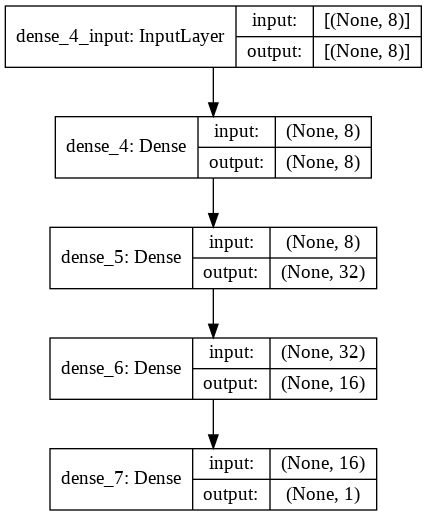

In [32]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)
